Tripartite GFP Project
==============
The goal of this project is to create a tripartite GFP that can be used to test for ScFv binding to a protein within a cell. 

The information on tripartite GFP comes from Cabantous 2013: "A New Protein-Protein Interaction Sensor
Based on Tripartite Split-GFP Association" [[link]](http://www.nature.com/srep/2013/131004/srep02854/full/srep02854.html) 
and its supplementary information [[link]](http://www.nature.com/srep/2013/131004/srep02854/extref/srep02854-s1.pdf).

The information on ScFv comes from Ferrara 2011: "Fluorescent Labeling of Antibody Fragments Using Split GFP" 
[[link]](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0025727), 
which uses an older system derived from a bipartite GFP.

A superfolder GFP is split into three parts and is used for testing the binding of two proteins (A and B, see image below):
- GFP1-9 (most of the GFP, but non-functional)
- GFP10 (a short tag attached to protein A)
- GFP11 (a short tag attached to protein B)



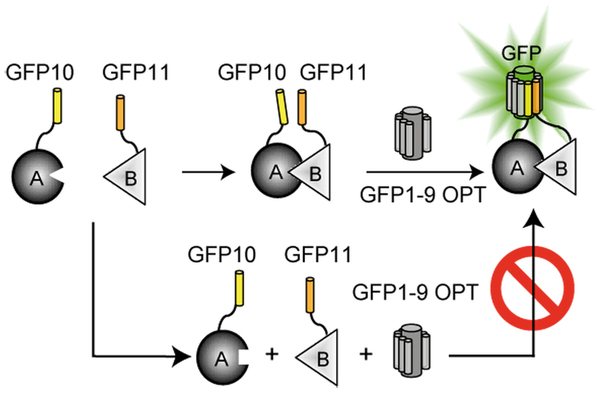

In [4]:
Image("tripartite_GFP.jpg")

In [26]:
# Setup cell
from __future__ import print_function, division

import re
import logging
import requests
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from StringIO import StringIO
from pprint import pprint
from IPython.display import display, Image, HTML, SVG

from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

# Printing a few different ways
def uprint(astr): print(astr + "\n" + "-"*len(astr))
def show_html(astr): return display(HTML('{}'.format(astr)))
def show_svg(astr, w=1000, h=1000):
    SVG_HEAD = '''<?xml version="1.0" standalone="no"?><!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">'''
    SVG_START = '''<svg width="{w:}px" height="{h:}px" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink= "http://www.w3.org/1999/xlink">'''
    return display(SVG(SVG_HEAD + SVG_START.format(w=w, h=h) + astr + '</svg>'))

def table_print(rows, header=True):
    html = ["<table>"]
    html_row = "</td><td>".join(k for k in rows[0])
    html.append("<tr style='font-weight:{}'><td>{}</td></tr>".format('bold' if header is True else 'normal', html_row))
    for row in rows[1:]:
        html_row = "</td><td>".join(str(primer_design[k]) if k in primer_design else str(k) for k in row)
        html.append("<tr style='font-family:monospace;'><td>{:}</td></tr>".format(html_row))
    html.append("</table>")
    show_html(''.join(html))

# Plotting style
plt.rc("axes", titlesize=20, labelsize=15, linewidth=.25, edgecolor='#444444')
sns.set_context("notebook", font_scale=1.2, rc={})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Experiment #1 :: a tripartite GFP to detect K1–E1 binding
========
The simplest tripartite GFP system uses K1–E1 binding and E1–E1 repulsion to test the system.

It comprises the following parts (see Figure 4a from Cabantous below):  
- GFP10
- GFP10 linker (l1)
- K1
- K1-E1 linker/IRBS
- E1
- GFP11 linker (l2)
- GFP11
- GFP1-9 (on a separate transciptional unit). 

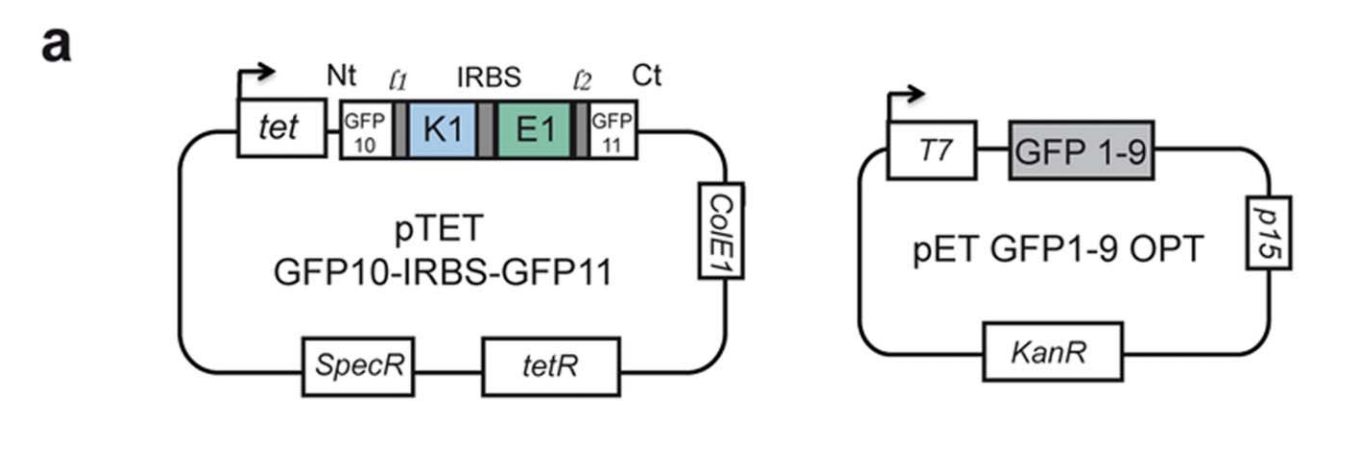

In [93]:
Image("K1_E1.png", width=600)

K1 and E1
-----
First, we will generate the sequences of the K1 and E1 domains. The K1 and E1 amino acid sequences are in the supplemental material. 
The codons were generated for E. coli with [IDT Codon Optimizer](https://www.idtdna.com/CodonOpt)

    E and K coils are constituted by five repeated heptads of the EVSALEK or KVSALKE motifs 

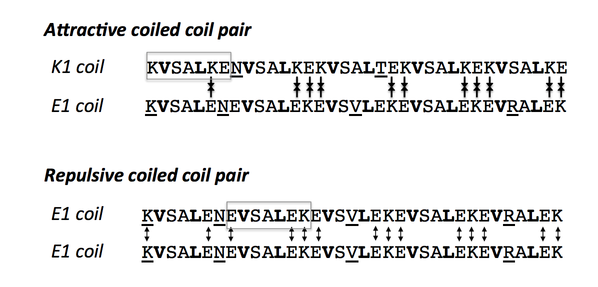

In [95]:
Image("K1_E1_aas.png", width=500)

In [24]:
K1_aa_seq = "KVSALKE NVSALKE KVSALTE KVSALKE KVSALKE".replace(" ","")
E1_aa_seq = "KVSALEN EVSALEK EVSVLEK EVSALEK EVRALEK".replace(" ","")

#         K  V  S  A   L  K  E   N  V
K1_seq = "AAAGTGTCAG CCCTGAAGGA GAATGTCTCC GCTCTGAAGG AAAAAGTTAG TGCACTGACT GAAAAAGTCT CTGCGCTGAA GGAGAAAGTT TCTGCTCTTA AGGAA"
#         K  V  S  A   L  E  N   E  V
E1_seq = "AAAGTCAGTG CACTGGAAAA CGAGGTATCG GCACTGGAAA AGGAGGTGTC GGTTCTCGAA AAAGAAGTGT CCGCGCTGGA GAAAGAGGTT CGGGCCCTGG AAAAA"
K1_seq, E1_seq = K1_seq.replace(" ",""), E1_seq.replace(" ","")

GFP
===
Now we have the sequence of K1 and E1, we need the sequence of GFP, split into GFP1-9, GFP10 and GFP11.

Based on BLASTP of a sequence in the supplement, the most likely GFP they use is this superfolder GFP: http://www.ncbi.nlm.nih.gov/protein/379069012

    MSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATIGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTISF # GFP1-9 (1-100)
    KDDGKYKTRAVVKFEGDTLVNRIELKGTDFKEDGNILGHKLEYNFNSHNVYITADKQKNGIKANFTVRHNVEDGSVQLADHYQQNTPIGDGPV # GFP1-9 (101-193)
    LLPDNHYLSTQTVLSKDPN # GFP10 (194-212)
    EKRDHMVLHEYVNAAGITLGM  # GFP11 (213-233)
    DELYK # 234-238

Mutating to optimize sfGFP
--------------------------
The paper shows (only as an image) how to mutate sfGFP to optimize folding for this application. 
If the sfGFP I have used ([AFC90853.1](http://www.ncbi.nlm.nih.gov/protein/379069012)) is the correct one, then the mutations should match. 
Indeed, the length of the two sequences are identical (238 aas) and all but one mutation (N105T) matches what I expect.

The output is an optimized version of the genbank sfGFP, sfGFP_opt.

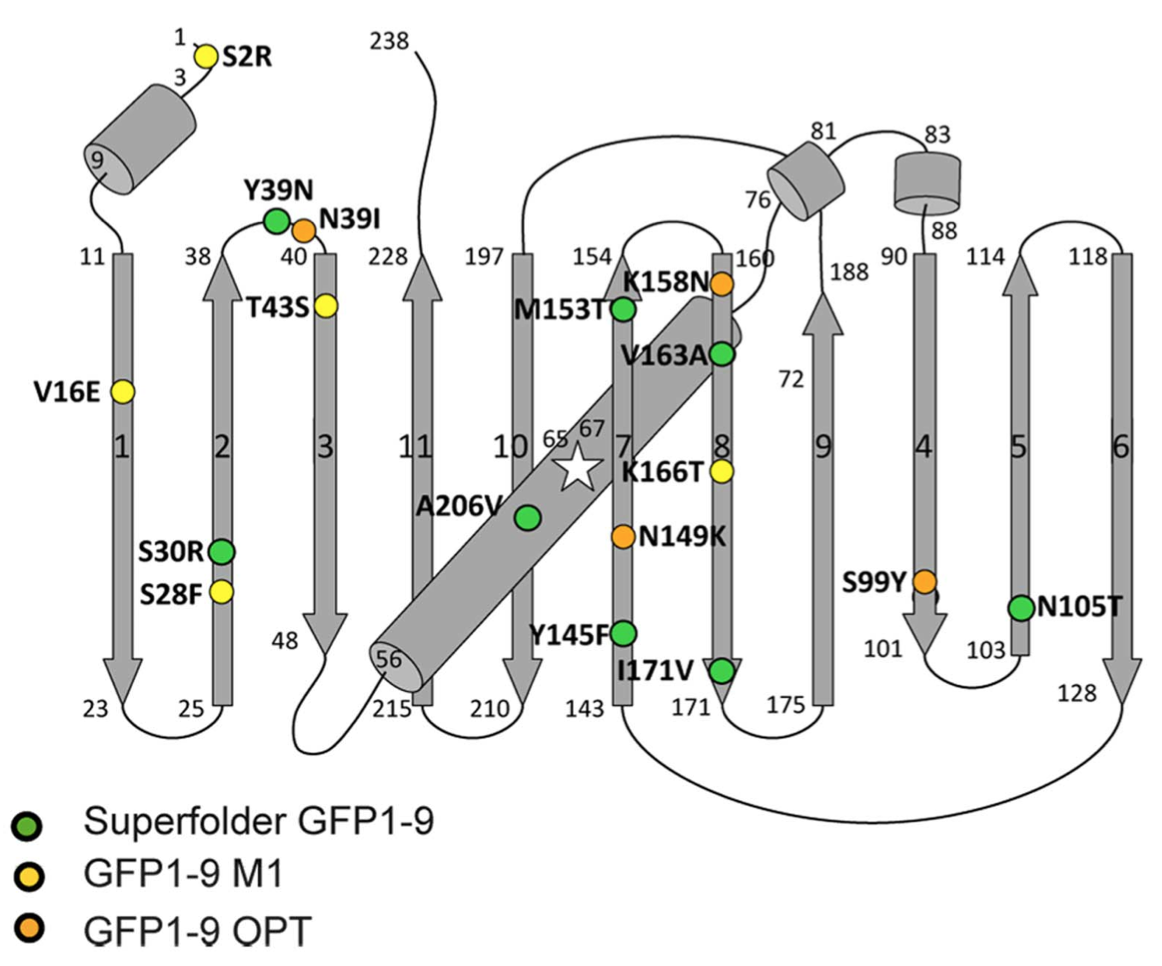

In [68]:
Image("sfGFP_muts.png", width=500)

In [96]:
# Start with an sfGFP from genbank, AFC90853.1
# Mutate it to the "opt" version from the paper
sfGFP_53 = '''MSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATIGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTISF
KDDGKYKTRAVVKFEGDTLVNRIELKGTDFKEDGNILGHKLEYNFNSHNVYITADKQKNGIKANFTVRHNVEDGSVQLADHYQQNTPIGDGPV
LLPDNHYLSTQTVLSKDPNEKRDHMVLHEYVNAAGITLGMDELYK'''.replace(" ","").replace("\n","")

opt_muts = "S2R V16E S28F S30R Y39I T43S S99Y N105T Y145F M153T K158N Y163A K166T I171V A206V"

sfGFP_53l = list(sfGFP_53)
for mut in opt_muts.split():
    aa1, posn, aa2 = mut[0], int(mut[1:-1])-1, mut[-1]
    if sfGFP_53l[posn] == aa1:
        sfGFP_53l[posn] = aa2
    elif sfGFP_53l[posn] == aa2:
        pass
    else:
        logging.warn("Unexpected mismatch: {} {}".format(mut, sfGFP_53l[posn]))
        
sfGFP_opt = ''.join(sfGFP_53l)

GFP1-9, GFP10, GFP11
------------------
Compare GFP chunks determined by the residues given in the paper (1-193, 194-212, 213-233) 
to the sequences of GFP10 and GFP11 given in the supplementary material.

There are major differences between the calculated sequence and the sequence from the supplementary material.
The major concerning difference is the addition of an M at the start of GFP10. 
I am not sure where this comes from or what it means about the sequence of GFP1-9.

I believe it makes most sense to use the GFP10 and GFP11 sequences from the paper directly, since these have been evolved for the tripartite assay.
Since no sequence for GFP1-9 is given in the paper, I must rely on the sequence I got (and optimized) from GenBank. 
This should work fine, since the mutations given map exactly onto this sequence, and the space between beta-barrels where 
GFP1-9 and GFP10 are split is about 10aas long, so there should be some leeway.

In [105]:
# by residue position only
bynum_GFP19 = sfGFP_opt[1-1:193] # Cabantous page 4
bynum_GFP10 = sfGFP_opt[194-1:212] # Cabantous page 4
bynum_GFP11 = sfGFP_opt[213-1:233] # Cabantous page 4

# according to the supplementary material
s1_GFP10 = "MDLPDDHYLSTQTILSKDLN"
s1_GFP11 = "EKRDHMVLLEYVTAAGITDAS"

uprint("GFPs by residue position only (nm) and the sequence from supplement S1 (s1)")
print("nm GFP19", bynum_GFP19[:100])
print("        ", bynum_GFP19[100:], len(bynum_GFP19))
print()
print("nm GFP10 ", bynum_GFP10, len(bynum_GFP10))
print("s1 GFP10", s1_GFP10, len(s1_GFP10))
print()
print("nm GFP11", bynum_GFP11, len(bynum_GFP11))
print("s1 GFP11", s1_GFP11, len(s1_GFP11))



GFPs by residue position only (nm) and the sequence from supplement S1 (s1)
---------------------------------------------------------------------------
nm GFP19 MRKGEELFTGVVPILEELDGDVNGHKFFVRGEGEGDATIGKLSLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIYF
         KDDGKYKTRAVVKFEGDTLVNRIELKGTDFKEDGNILGHKLEYNFNSHNVYITADKQNNGIKANFTVRHNVEDGSVQLADHYQQNTPIGDGPV 193

nm GFP10  LLPDNHYLSTQTVLSKDPN 19
s1 GFP10 MDLPDDHYLSTQTILSKDLN 20

nm GFP11 EKRDHMVLHEYVNAAGITLGM 21
s1 GFP11 EKRDHMVLLEYVTAAGITDAS 21


Interestingly, the by-residue version of GFP11 matches the GFP11 sequence from Waldo's 2011 paper on a bipartite GFP (GFP1-10 and GFP11) with a couple of minor differences (see image below).

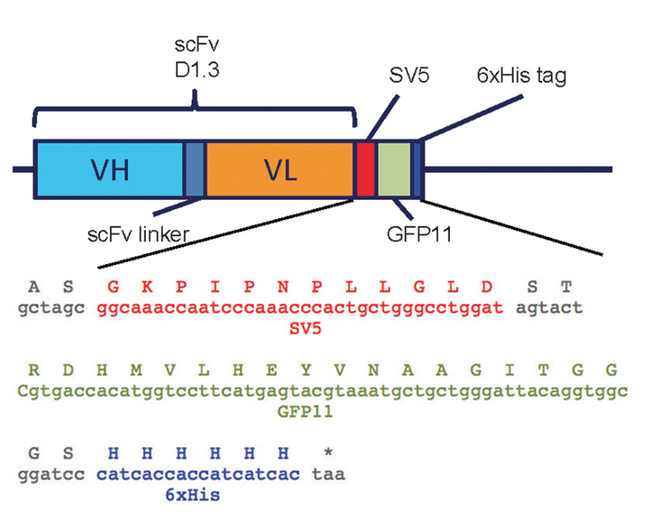

In [89]:
Image("gfp11_scfv.png", width=300)

Using PDB, we can examine the structure of a closely-related sfGFP ([4J8A](http://www.rcsb.org/pdb/explore/remediatedSequence.do?structureId=4J8A)).
We can see that there is a big chunk of sequence (188-198) between two beta-barrels, so it should be reasonable to cut anywhere in this region. 
The sequence here very closely matches my sfGFP sequence and also agrees with the image from the tripartite GFP paper that shows the location of mutations.

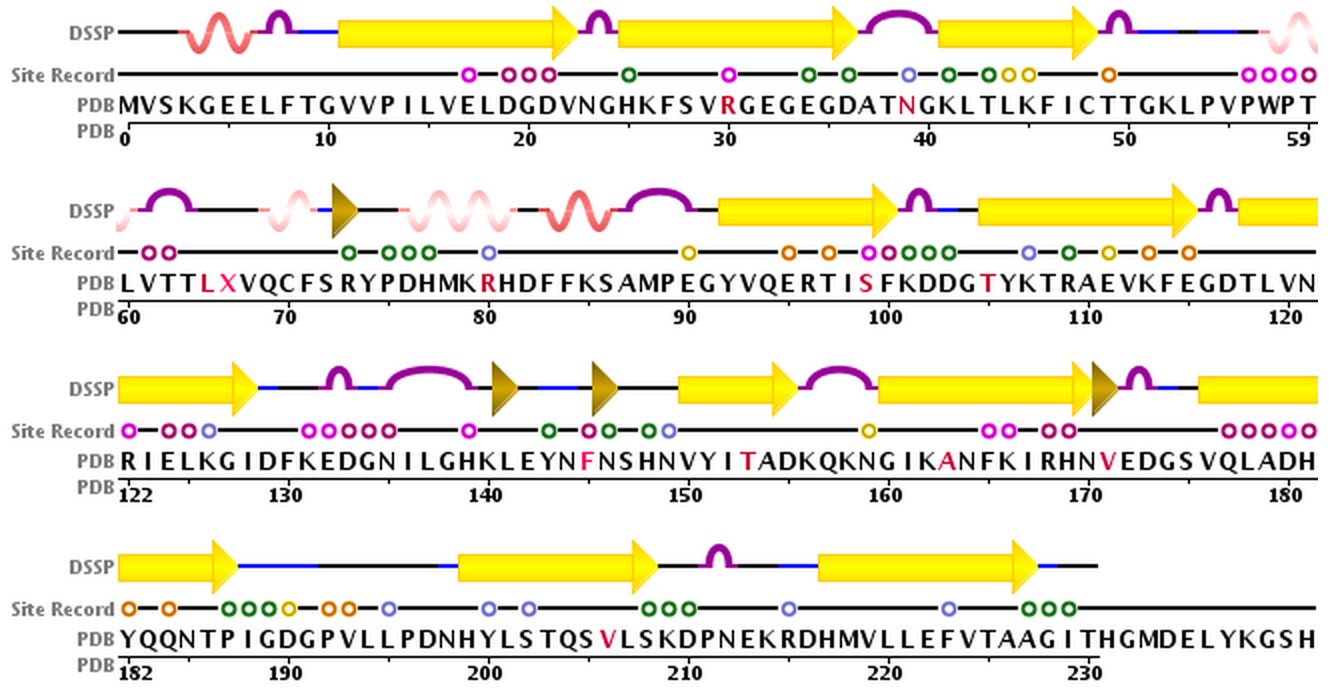

In [92]:
Image("gfp_pdb.png", width=400)

Reverse translation
-----------------
Reverse-translated offline using IDT's codon optimizer, with E. coli as the target organism

In [513]:
nm_GFP19_dna = '''
ATGCGTAAGG GTGAGGAGCT TTTTACTGGA GTCGTTCCGA TTCTGGAAGA ACTGGATGGT
GATGTAAATG GTCACAAATT TTTTGTGCGC GGCGAAGGAG AAGGCGACGC GACAATCGGG
AAACTTAGTC TGAAATTCAT CTGCACCACG GGGAAGCTGC CCGTGCCGTG GCCCACCCTG
GTTACAACCC TTACATACGG TGTACAGTGC TTCAGTCGGT ATCCGGATCA TATGAAGCGT
CACGACTTTT TTAAAAGCGC GATGCCGGAA GGTTATGTGC AAGAGCGCAC AATTTACTTT
AAGGATGATG GTAAATATAA AACGCGTGCT GTCGTTAAAT TTGAAGGTGA CACGCTGGTT
AACCGCATTG AATTGAAAGG GACCGATTTC AAAGAAGATG GCAATATCCT TGGTCACAAG
CTGGAATATA ACTTTAACAG TCACAATGTC TATATCACCG CCGACAAACA AAATAACGGT
ATTAAAGCCA ATTTCACGGT CCGGCATAAT GTGGAGGACG GTTCCGTGCA GCTGGCCGAT
CATTACCAAC AGAACACGCC AATTGGCGAT GGCCCGGTG'''.replace('\n','').replace(' ','')
s1_GFP10_dna = 'ATGGACCTTC CCGATGATCA TTATTTGAGC ACCCAGACTA TCCTGTCAAA AGACTTAAAT'.replace(' ','')
s1_GFP11_dna = 'GAAAAACGCG ACCATATGGT ACTCTTAGAG TATGTGACCG CGGCCGGTAT CACAGATGCG TCT'.replace(' ','')

uprint("Length of translated proteins")
print("GFP1-9:{} GFP10:{} GFP11:{}".format(len(nm_GFP19_dna)/3, len(s1_GFP10_dna)/3, len(s1_GFP11_dna)/3))

Length of translated proteins
-----------------------------
GFP1-9:193.0 GFP10:20.0 GFP11:21.0


Linkers
====
We need two linkers to connect GFP10 to Protein A and GFP11 to Protein B, 
as well as an internal linker that contains an IRBS. 
The sequences are given in Supplementary Figure S3.

Note:
- GFP10 ends in DLN like s1_GFP10, not DPN like nm_GFP10.

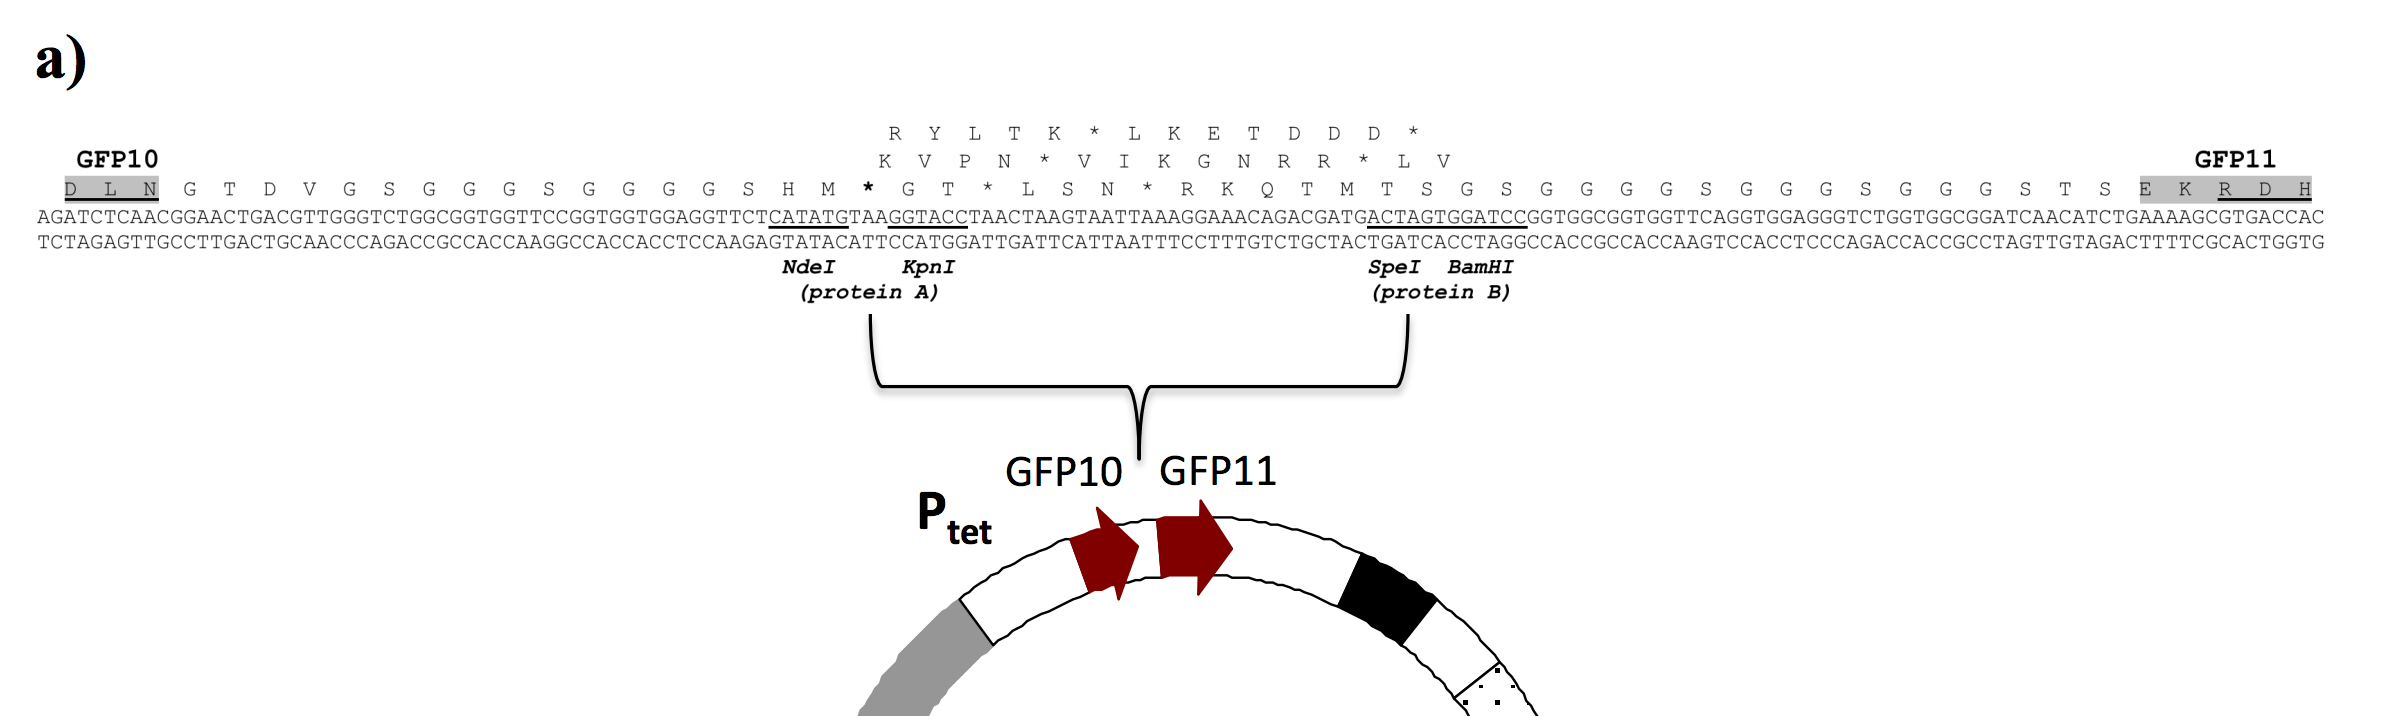

In [25]:
Image("linker1.png")

QC
--
Here I make sure that the DNA sequence, copied down from the image above, matches the amino acid sequence.

I note the presence of a Shine-Dalgarno sequence (labeled S-D) that will allow for translation of the GFP11 linker and GFP11.

In [409]:
# GFP10 start. 
# DLN is the end of s1_GFP10 (note the very first A in the sequence we can see in the image was not included here)
#
#           D  L  N  
lnk_seqa = "GATCTCAAC"
lka_seqa = "D  L  N  ".replace(' ','')

# GFP10 linker
#
#           G  T  D  V  G  S  G  G  G  S  G  G  G  G  S  H  M  *
#                                                        Nde1 (CATATG)
#                                                        ______
lnk_seq1 = "GGAACTGACGTTGGGTCTGGCGGTGGTTCCGGTGGTGGAGGTTCTCATATGTAA"
lka_seq1 = "G  T  D  V  G  S  G  G  G  S  G  G  G  G  S  H  M  *  ".replace(' ','')

# IRBS linker
#
#           G  T  *  L  S  N  *  R  K  Q  T  M  T  S  
#            KpnI (GGTACC)              (ACTAGT) SpeI 
#           ______                              ______
#                                S-D         Met (with 8nt gap)
#                                ____        ___
lnk_seq2 = "GGTACCTAACTAAGTAATTAAAGGAAACAGACGATGACTAGT"
lka_seq2 = "G  T  *  L  S  N  *  R  K  Q  T  M  T  S  ".replace(' ','')

# GFP11 linker
#
#           G  S  G  G  G  G  S  G  G  G  S  G  G  G  S  T  S
#           BamHI (GGATCC)
#           ______
lnk_seq3 = "GGATCCGGTGGCGGTGGTTCAGGTGGAGGGTCTGGTGGCGGATCAACATCT"
lka_seq3 = "G  S  G  G  G  G  S  G  G  G  S  G  G  G  S  T  S  ".replace(' ','')

# GFP11 start
# EKRDH is the start of GFP11
#           E  K  R  D  H
lnk_seqz = "GAAAAGCGTGACCAC"
lka_seqz = "E  K  R  D  H".replace(' ','')

cdn_dna1 = Seq(lnk_seq1, generic_dna)
assert cdn_dna1.translate() == lka_seq1

cdn_dna2 = Seq(lnk_seq2, generic_dna)
assert cdn_dna2.translate() == lka_seq2

cdn_dna3 = Seq(lnk_seq3, generic_dna)
assert cdn_dna3.translate() == lka_seq3

Longer linkers for larger proteins
--------------------------------
The authors use longer linkers for >50kD proteins.
Note that the actual length of the long linkers given in the paper are 96 nucleotides (32x3) and 75 nucleotides (25x3), not 90 and 75 as stated in the image below.

Note for K1–E1 binding, I do not usre these longer linkers.

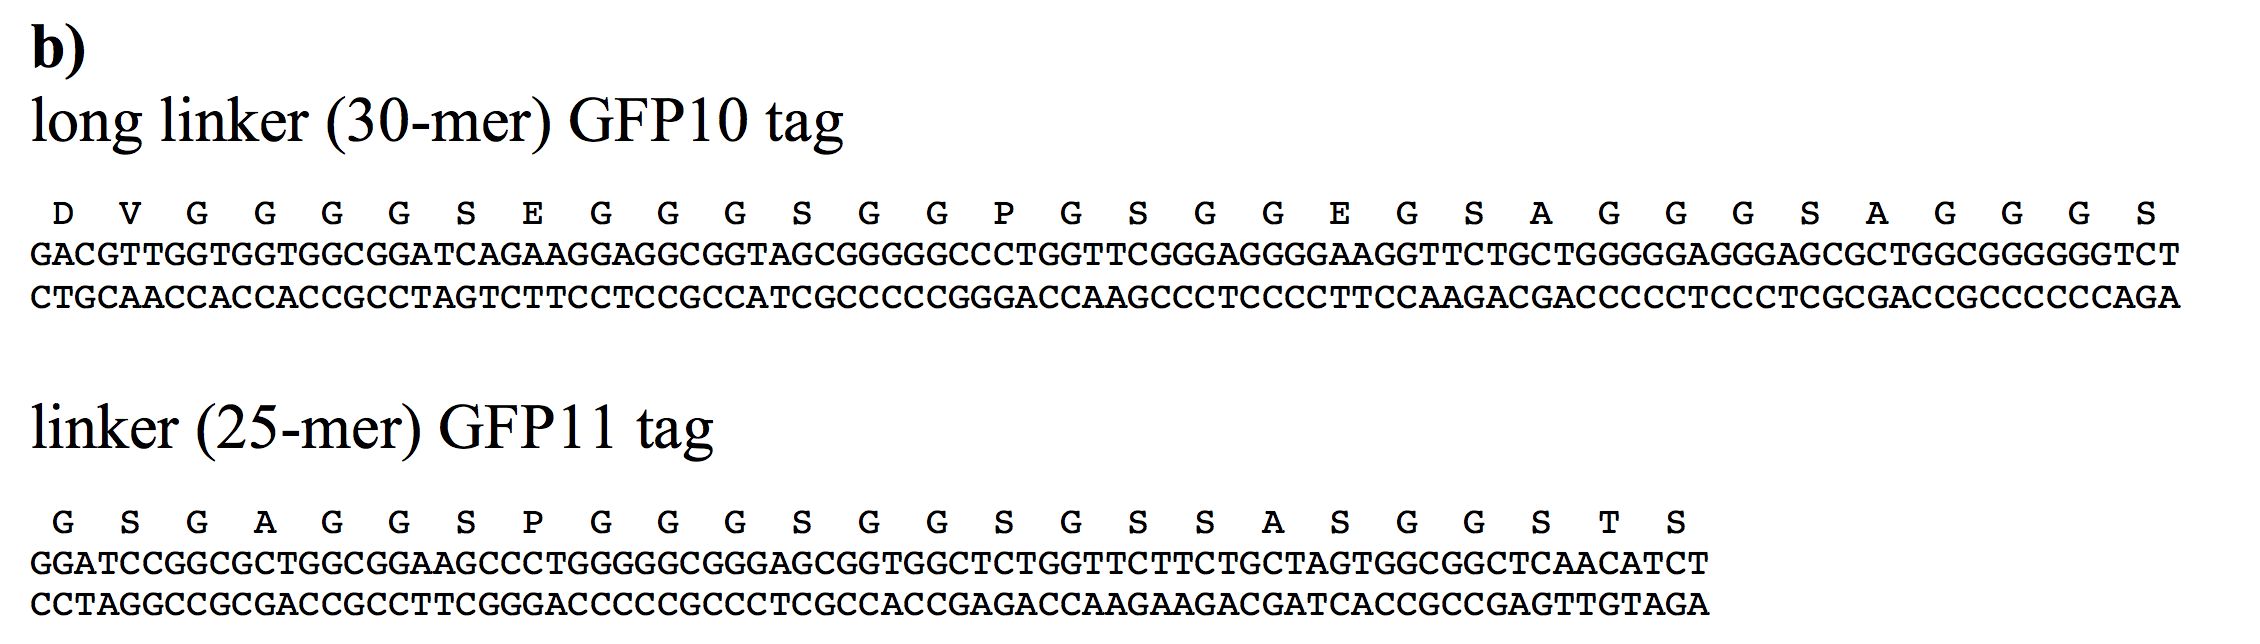

In [42]:
Image("linker2.png", width=500)

In [49]:
gfp10_long_linker = "GACGTTGGTGGTGGCGGATCAGAAGGAGGCGGTAGCGGGGGCCCTGGTTCGGGAGGGGAAGGTTCTGCTGGGGGAGGGAGCGCTGGCGGGGGGTCT"
gfp11_long_linker = "GGATCCGGCGCTGGCGGAAGCCCTGGGGGCGGGAGCGGTGGCTCTGGTTCTTCTGCTAGTGGCGGCTCAACATCT"

assert len(gfp10_long_linker) == 32*3 and len(gfp11_long_linker) == 25*3
print("Length of long linkers (in nucleotides): ", len(gfp10_long_linker), len(gfp11_long_linker))

Length of long linkers (in nucleotides):  96 75


Assembling
=========
Assemble all the parts.

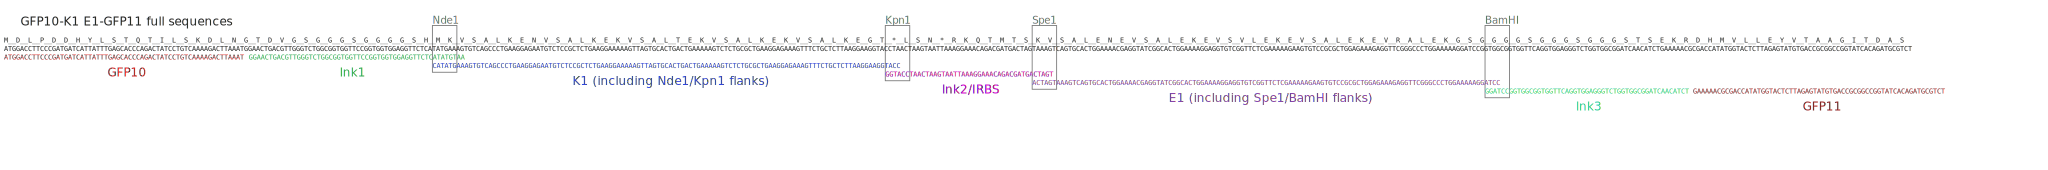

In [515]:
from collections import namedtuple

_pnames = " name                                seq            lvl  col        cut   lenrs rs"
_params = [("GFP10",                            s1_GFP10_dna,  4  , "#dd2222", 0,    0,    None),
           ("lnk1" ,                            lnk_seq1    ,  4  , "#33aa55", 3,    0,    None),
           ("K1 (including Nde1/Kpn1 flanks)",  Nde1_K1_Kpn1,  5  , "#3344dd", 0,    6,    "Nde1"),
           ("lnk2/IRBS",                        lnk_seq2,      6  , "#cc00cc", 0,    6,    "Kpn1"),
           ("E1 (including Spe1/BamHI flanks)", Spe1_E1_BamHI, 7  , "#8844aa", 0,    6,    "Spe1"),
           ("lnk3",                             lnk_seq3,      8  , "#33cc99", 0,    6,    "BamHI"),
           ("GFP11",                            s1_GFP11_dna,  8  , "#992222", 0,    0,    None)
          ]

Paramt = namedtuple('Paramt', _pnames.strip().split())
params = [Paramt(*p) for p in _params]

Nde1 = "CATATG"
Kpn1 = "GGTACC"
Nde1_K1_Kpn1 = Nde1 + K1_seq + Kpn1

SpeI = "ACTAGT"
BamHI = "GGATCC"
Spe1_E1_BamHI = SpeI + E1_seq + BamHI


def txt(seq, x, y, col):
    return '<text x="{}" y="{}" fill="{}" font-size="8" font-family="monospace">{}</text>'.format(
        x*XW, (y+3)*YH, col, seq)

def ttl(txt, x, y, col):
    return '<text x="{}" y="{}" fill="{}" font-size="14" text-anchor="middle">{}</text>'.format(x*XW, (y+3)*YH, col, txt)
    
def rct(txt, x, y, w, h, col):
    return '<text x="{}" y="{}" fill="{}" font-size="12">{}</text>'.format(x*XW, (y+3)*YH-2, col, txt) + \
           '<rect x="{}" y="{}" width="{}" height="{}" style="fill:none;stroke:{};"></rect>'.format(
            x*XW, (y+3)*YH, w*XW, h*(YH)+5, col)

def params_to_svg(params):
    XW, YH = 4.8, 10
    posa, lena, full_seq, ssvg = 0, 0, '', []
    
    for p in params:
        p_seq = p.seq if p.cut == 0 else p.seq[:-p.cut]
        
        posa, lena = posa+lena-p.lenrs, len(p_seq)
        full_seq += p_seq[p.lenrs:]
        
        if p.rs: ssvg += [rct(p.rs, posa, 0, p.lenrs, p.lvl, "#777777")]
        ssvg += [txt(p.seq, posa, p.lvl, p.col)]
        ssvg += [ttl(p.name, posa+lena/2, p.lvl+2, p.col)]

    full_aas = '__'.join(Seq(full_seq, generic_dna).translate())
    lvl = 3
    ssvg += [txt(full_seq, 0, lvl, "#222222")]
    ssvg += [txt(full_aas, 0, lvl-1, "#222222")]
    ssvg += [ttl("GFP10-K1 E1-GFP11 full sequences", 30, lvl-3, "#222222")]

    return '\n'.join(ssvg)

show_svg(params_to_svg(params), w=2400, h=200)

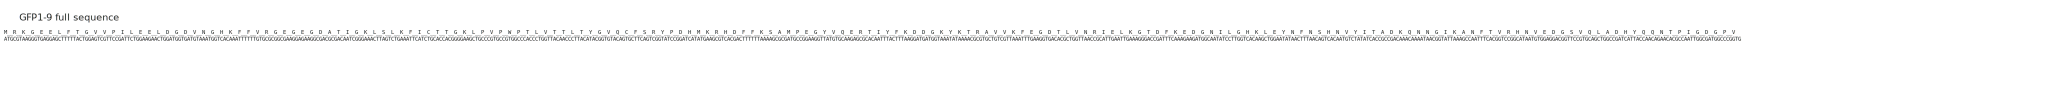

In [510]:
full_seq2 = nm_GFP19_dna
full_aas2 = '__'.join(Seq(full_seq2, generic_dna).translate())

ssvg = [txt(full_seq2, 0, 3, "#222222")]
ssvg += [txt(full_aas2, 0, 2, "#222222")]
ssvg += [ttl("GFP1-9 full sequence", 20, 0, "#222222")]
show_svg(''.join(ssvg), w=3000, h=150)